In [1]:
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
from matplotlib import pyplot as plt
from matplotlib import colors
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()

from one.api import ONE

from iblnm import config, util, io, vis

In [2]:
# Instantiate a database connection
one = ONE()

## Load session data

In [3]:
# Query for sessions in the ibl_fibrephotometry project
df_sessions = io.fetch_sessions(one, save=True, extended=False)

Querying database...


 30%|███████████████████████▊                                                        | 1075/3621 [11:19<23:51,  1.78it/s]local file size mismatch on dataset: mainenlab/Subjects/ZFM-08652/2025-03-27/001/alf/photometry/photometryROI.locations.pqt

(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-27/001/alf/photometry
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-27/001/alf/photometry
 30%|███████████████████████▊                                                        | 1076/3621 [11:22<54:17,  1.28s/it]local file size mismatch on dataset: mainenlab/Subjects/ZFM-08652/2025-03-26/001/alf/photometry/photometryROI.locations.pqt

(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-26/001/alf/photometry
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08652/2025-03-26/001/alf/photometry
 30%|███████████████

KeyboardInterrupt: 

> /home/davide/.local/share/uv/python/cpython-3.13.8-linux-x86_64-gnu/lib/python3.13/ssl.py(1138)read()
   1136         try:
   1137             if buffer is not None:
-> 1138                 return self._sslobj.read(len, buffer)
   1139             else:
   1140                 return self._sslobj.read(len)



ipdb>  c


In [4]:
# Load sessions from previous query
df_sessions = pd.read_parquet(config.SESSIONS_FPATH)  # raw output of io.fetch_sessions

## Get additional quality control info

#### Check for potential duplicate sesions (sessions with the same subject, date, and session type)

In [5]:
# Convert start_time to datetime and date columns
df_sessions['start_time_dt'] = df_sessions['start_time'].apply(datetime.fromisoformat)
df_sessions['date'] = df_sessions['start_time_dt'].dt.date
df_sessions['day_n'] = df_sessions.groupby('subject')['date'].transform(lambda x: [(date - x.min()).days for date in x])
df_sessions['session_n'] = df_sessions.groupby('subject')['date'].rank(method='dense')

# Add a flag to potential duplicates
df_sessions['duplicate_session'] = df_sessions.duplicated(subset=['subject', 'date', 'session_type'], keep=False)

#### Check that the raw behavioral data is present

In [6]:
# This info is already present in the sessions dataframe, we just make a new columns that are easier to work with
df_sessions['raw_taskData_exists'] = df_sessions[[col for col in df_sessions.columns if '_iblrig_taskData.raw.jsonable' in col]].apply(any, axis='columns')  # raw task data exists somewhere in Alyx
df_sessions['raw_taskData_in_sessionDict'] = df_sessions['datasets'].apply(lambda x: '_iblrig_taskData.raw.jsonable' in x)  # raw task data is listed as a dataset in the session dict

#### Get the number of trials in the session

  0%|▌                                                                                                                       | 15/3523 [00:04<19:50,  2.95it/s]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-09365/2025-10-08/001/raw_task_data_00/_iblrig_taskData.raw.jsonable:   0%
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-09365/2025-10-08/001/raw_task_data_00/_iblrig_taskData.raw.jsonable:  28%
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-09365/2025-10-08/001/raw_task_data_00/_iblrig_taskData.raw.jsonable: 100%
  0%|▌                                                                                                                     | 16/3523 [00:07<1:06:06,  1.13s/it]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-09377/2025-10-08/001/raw_task_data_00/_iblrig_taskData.raw.jsonable:   0%
(S3) /home/davide/Downloads/ONE/alyx.int

[Text(0, 0, 'n_trials_taskData'), Text(1, 0, 'n_trials_sessionDict')]

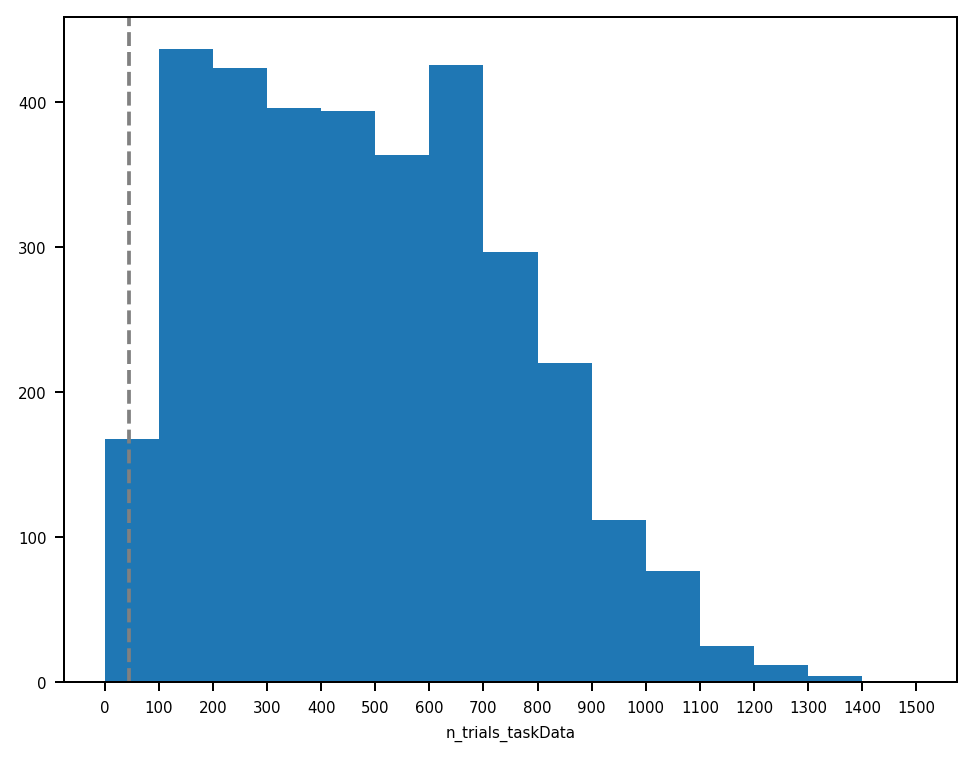

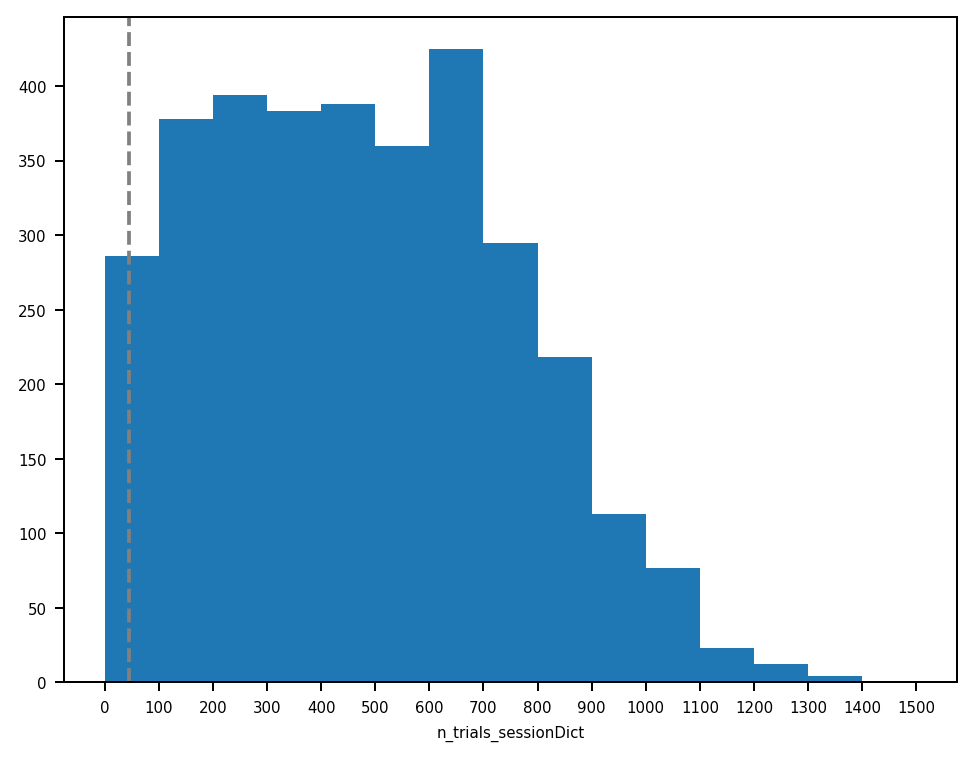

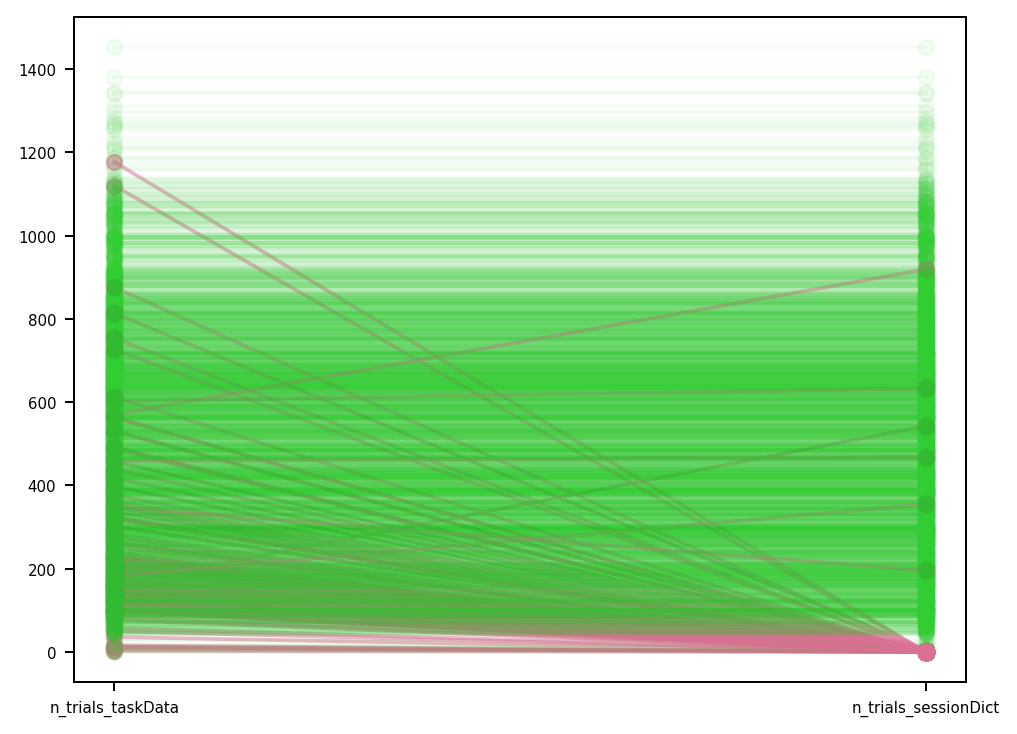

In [7]:
# Get n_trials for each session (Note: this takes some time so best not to re-run unless a new query is made)
df_sessions['n_trials_taskData'] = df_sessions.progress_apply(io._get_ntrials_from_raw_taskData, one=one, axis='columns')

# Rename n_trials column to be more descriptive
df_sessions['n_trials_sessionDict'] = df_sessions['n_trials'].copy()

# Restrict to sessions that have a raw behavior file
df_hasbehavior = df_sessions.query('raw_taskData_exists == True')

# Set a n_trials threshold
min_trials = config.MIN_NTRIALS

bins = np.arange(0, 1600, 100)
for col in ['n_trials_taskData', 'n_trials_sessionDict']:
    fig, ax = plt.subplots()
    ax.hist(df_hasbehavior[col], bins=bins)
    ax.axvline(min_trials, ls='--', color='gray')
    ax.set_xlabel(col)
    ax.set_xticks(bins)
    ax.set_xticklabels([f'{tick}' for tick in bins])

fig, ax = plt.subplots()
for _, session in df_hasbehavior.iterrows():
    color = 'limegreen' if session['n_trials_taskData'] == session['n_trials_sessionDict'] else 'palevioletred'
    alpha = 0.05 if session['n_trials_taskData'] == session['n_trials_sessionDict'] else 0.5
    ax.plot([0, 1], session[['n_trials_taskData', 'n_trials_sessionDict']], marker='o', color=color, alpha=alpha)
ax.set_xticks([0, 1])
ax.set_xticklabels(['n_trials_taskData', 'n_trials_sessionDict'])

## Note: seems that the vast majority of trial_n mistmatch is for 0s in the sessionDict

#### Get the session length

Text(0.5, 0, 'Session length (min)')

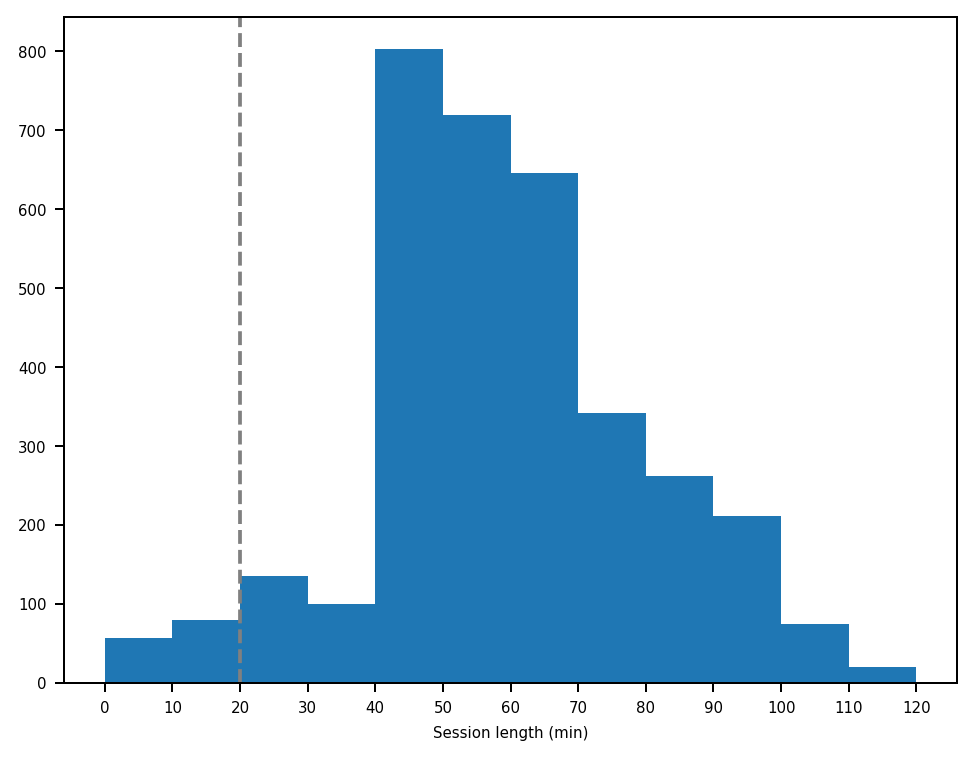

In [8]:
# Get session length each session
df_sessions['session_length'] = df_sessions.apply(util._get_session_length, axis='columns')

# Set a length threshold
min_len = config.MIN_SESSIONLENGTH

fig, ax = plt.subplots()
bins = np.arange(0, (120 + 10) * 60, 10 * 60)
ax.hist(df_sessions['session_length'], bins=bins)
ax.axvline(min_len, ls='--', color='gray')
ax.set_xticks(bins)
ax.set_xticklabels([f'{tick / 60:.0f}' for tick in bins])
ax.set_xlabel('Session length (min)')

#### Try to resolve duplicate sessions

In [9]:
def _resolve_session_status(session_group):
    """
    Resolve duplicate sessions by flagging them as 'good', 'junk', 'conflict', or 'missing'
    """
    # Create a copy to avoid modifying original data
    group = session_group.copy()
    
    # Initialize all sessions as 'junk'
    group['session_status'] = 'junk'
    
    # Find sessions that have behavior data AND meet quality criteria (trials OR length)
    good_sessions_mask = (
        group['raw_taskData_exists'] & 
        (
            (group['n_trials_sessionDict'] > config.MIN_NTRIALS) | 
            (group['session_length'] > config.MIN_SESSIONLENGTH)
        )
    )
    good_sessions = group[good_sessions_mask]
    
    if len(good_sessions) == 1:
        # One session has behavior and quality - mark as 'good', others remain 'junk'
        group.loc[good_sessions.index, 'session_status'] = 'good'
        
    elif len(good_sessions) > 1:
            group.loc[good_sessions.index, 'session_status'] = 'conflict'
    
    # No sessions in group have raw task data & sufficient trials or length
    else:
        # Check for rare cases where there is no raw task data in Alyx, 
        # but the session dictionary says there should be
        missing_behavior_mask = (
            group['raw_taskData_in_sessionDict'] & 
            ~group['raw_taskData_exists'] & 
            (group['n_trials_sessionDict'] > config.MIN_NTRIALS)
        )
        missing_sessions = group[missing_behavior_mask]
        
        if len(missing_sessions) == 1:
            # Single session with missing behavior - mark as 'missing'
            group.loc[missing_sessions.index, 'session_status'] = 'missing'
        elif len(missing_sessions) > 1:
            # Multiple sessions with missing behavior - mark as 'missing_conflict'
            group.loc[missing_sessions.index, 'session_status'] = 'missing_conflict'
    
    return group['session_status']

# Apply the function to resolve duplicates
df_sessions['session_status'] = df_sessions.groupby(['subject', 'date', 'session_type'], group_keys=False).apply(_resolve_session_status, include_groups=False)

# Check that there are no remaining duplciates among the good sessions
assert all(df_sessions.query('session_status in ["good", "missing"]').groupby(['subject', 'date', 'session_type']).apply(len, include_groups=False) == 1)

#### Save df_sessions with new columns, add timestamp

In [10]:
io.save_as_pqt(df_sessions, config.SESSIONS_FPATH.split('.')[0] + f'_{datetime.now().strftime("%Y-%m-%d-%H:%M:%S")}.pqt')

#### Outcomes
Restrict the rows and columns of df_sessions to create a more targeted subset for QC.

In [41]:
df_sessions['alyx_photometry'] = df_sessions.apply(lambda x:
    all([x[col] for  col in ['alf/photometry/photometry.signal.pqt', 'alf/photometry/photometryROI.locations.pqt']]),
    axis='columns'
    )

In [42]:
# List of filtering operations to apply (joined by AND)
filter_list = [
    '(session_type not in @session_types_to_exclude)',
    '(subject not in @subjects_to_exclude)',
]
# filter_list = []  # empty list to take all sessions

# Define varibales referenced in filter list
session_types_to_exclude = config.EXCLUDE_SESSION_TYPES
subjects_to_exclude = config.EXCLUDE_SUBJECTS

# Apply the filters
if filter_list:
    df_qc = df_sessions.query(' and '.join(filter_list)).copy()
else:
    df_qc = df_sessions.copy()

columns_to_include = [
    'eid', 'session_status', 'subject', 'target', 'NM',
    'day_n', 'session_n', 'start_time', 'end_time', 'session_length', 
    'task_protocol', 'session_type', 'duplicate_session',
    'raw_taskData_exists', 'n_trials_taskData', 'n_trials_sessionDict', 
    'alyx_photometry'
]
df_qc = df_qc[columns_to_include].sort_values(['subject', 'start_time']).copy()

Load a previous df_qc

In [32]:
# df_qc = pd.read_parquet('session_qc/session_qc_2025-08-27-17:36:11.pqt')

Print a summary of the QC outcomes

In [43]:
# Print the number of sessions
print(f"Total sessions: {len(df_qc)}")

# Display duplicate session resolutions
print(df_qc['session_status'].value_counts())

# Save QC data
# session_qc_path = Path("session_qc")
# session_qc_path.mkdir(exist_ok=True)
# df_qc.to_csv(session_qc_path / 'session_qc.csv')
# df_qc.query('session_status == "conflict"').to_csv(session_qc_path / 'conflict.csv')
# df_qc.query('not duplicate_session & not raw_taskData_exists').to_csv(session_qc_path / 'missing_taskData.csv')
# df_qc.query('raw_taskData_exists & (n_trials_sessionDict != n_trials_taskData)').to_csv(session_qc_path / 'check_taskData_extraction.csv')

Total sessions: 3185
session_status
good        2970
junk         114
conflict     101
Name: count, dtype: int64


## Dataset overview

In [44]:
# best to view this one in an interactive window
%matplotlib qt  

# Pick a time-base (x-axis) for the plot
# columns = 'day_n'  # to see the actual timeline
columns = 'session_n'  # to see a condensed representation of the sessions

ax = vis.session_overview_matrix(df_qc, columns=columns)

In [23]:
df_qc['has_targets'] = df_qc['target'].apply(lambda x: len(x) > 0)

In [45]:
# df_qc.loc[~df_qc['has_targets'] & (df_qc['session_status'] == 'good'), 'session_status'] = 'no_photometry'
df_qc.loc[~df_qc['alyx_photometry'] & (df_qc['session_status'] == 'good'), 'session_status'] = 'no_photometry'
ax = vis.session_overview_matrix(df_qc, columns=columns)

In [47]:
# Consider only good sessions with photometry targets
df_photometry = df_qc.query('session_status == "good"').copy()
# df_photometry_sessions = df_photometry.loc[df_photometry['has_targets']]
df_photometry_sessions = df_photometry.loc[df_photometry['alyx_photometry']]

print(f"Total sessions: {len(df_photometry)}")
print(f"Sessions with targets: {len(df_photometry_sessions)}")

valid_targets = [
    'VTA',
    'SNc',
    'DR',
    'MR',
    'LC',
    'NBM',
    'SI',
    'PPT'
]

df_photometry_sessions = df_photometry_sessions.explode(column='target').dropna(subset='target')
df_photometry_sessions['target'] = df_photometry_sessions['target'].replace({'NMB': 'NBM', 'SNC': 'SNc'})
df_photometry_sessions = df_photometry_sessions.query('target.isin(@valid_targets) and NM != "none"').copy()
df_photometry_sessions['target_NM'] = df_photometry_sessions.apply(lambda x: '-'.join([x['target'], x['NM']]), axis='columns')

Total sessions: 1527
Sessions with targets: 1527


In [48]:
%matplotlib qt

# Create a target_NM x session_type matrix with session counts
df_nsessions = df_photometry_sessions.pivot_table(columns='session_type', index='target_NM', aggfunc='size', fill_value=0)

# Loop over session types for a stacked bar plot
fig, ax = plt.subplots()
xpos = [config.TARGETNM2POSITION[target_NM] for target_NM in df_nsessions.index]
ypos = np.zeros(len(df_nsessions))  # bar heights start at 0
width = 0.8  # bar width
for session_type in ['training', 'biased', 'ephys']:
    n_sessions = df_nsessions[session_type]
    ax.bar(xpos, n_sessions, bottom=ypos, width=width, color=config.SESSIONTYPE2COLOR[session_type], label=session_type)
    for i, (x, n, y_bottom) in enumerate(zip(xpos, n_sessions, ypos)):
        if n > 0:  # only show text if there are sessions
            ax.text(x, y_bottom + n/2, str(n), 
                   ha='center', va='center', 
                   fontweight='bold', fontsize=vis.LABELFONTSIZE,
                   color='white')
    ypos += n_sessions
ax.set_xticks(list(xpos))
n_mice = df_photometry_sessions.groupby('target_NM').apply(lambda x: len(x['subject'].unique()))
ax.set_xticklabels(['%s\n(%d mice)' % (target_NM, n_mice.loc[target_NM]) for target_NM in df_nsessions.index])
ax.set_xlim(right=max(xpos) + width)
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.arange(0, np.ceil(max(ypos) / 100) + 1) * 100)
ax.set_ylabel('N Sessions')
ax.legend()

n_recordings = len(df_photometry_sessions)
n_sessions = len(df_photometry_sessions.groupby('eid'))
n_mice = len(df_photometry_sessions.groupby('subject'))
ax.set_title(f"{n_recordings} recordings, {n_sessions} sessions, {n_mice} mice ({datetime.today().strftime('%Y-%m-%d')})")

vis.set_plotsize(w=12, h=6)

/tmp/ipykernel_2282776/1443168187.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_mice = df_photometry_sessions.groupby('target_NM').apply(lambda x: len(x['subject'].unique()))


In [21]:
%matplotlib qt

# columns = 'day_n'  # to see the actual timeline
columns = 'session_n'  # to see a condensed representation of the sessions

ax = vis.session_overview_matrix(df_photometry, columns=columns)

In [125]:
%matplotlib qt

for target_NM in df_photometry['target_NM'].unique():
    ax = vis.session_overview_matrix(
        df_photometry.query('(session_status == "good") & (target_NM == @target_NM)'),
        columns='day_n'
    )
    ax.set_title(target_NM)
    ax.get_figure().savefig(f'session_qc/IBL-NM_timeline_overview_{target_NM}.pdf')

## Perform detailed QC

#### Apply some a filter and sort the sessions

In [120]:
# List of filtering operations to apply (joined by AND)
filter_list = [
    '(date > @cutoff_date)',
    '(session_type != "habituation")',
    '(session_status in @resolved)',
    '(lab == @lab)',
]
# filter_list = []  # empty list to take all sessions

# Define varibales referenced in filter list
cutoff_date = datetime(2024, 4, 1).date()
status = ["good"]
lab = 'mainenlab'

# Apply the filters
if filter_list:
    df_qc = df_sessions.query(' and '.join(filter_list)).copy()
else:
    df_qc = df_sessions.copy()

# Sort rows
df_qc = df_qc.sort_values(['subject', 'date'])

# Print out some summary data
print(f"N Sessions: {len(df_qc)}")
print(f"N Mice: {len(df_qc['subject'].unique())}")
print(df_qc['subject'].unique())

N Sessions: 497
N Mice: 22
['VIV-45585' 'VIV-45598' 'VIV-47615' 'VIV-47627' 'ZFM-08488' 'ZFM-08551'
 'ZFM-08554' 'ZFM-08652' 'ZFM-08689' 'ZFM-08751' 'ZFM-08757' 'ZFM-08776'
 'ZFM-08813' 'ZFM-08814' 'ZFM-08818' 'ZFM-08827' 'ZFM-08828' 'ZFM-08863'
 'ZFM-08871' 'ZFM-09044' 'ZFM-09139' 'ZFM-09140']


#### Plot QC outcomes for a given category of tests

In [121]:
# Print out some potential QC categories to examine
np.unique([col.split('_')[1] for col in df_qc.columns if col.startswith('qc')])

array(['behavior', 'dlcBody', 'dlcLeft', 'dlcRight', 'session', 'task',
       'videoBody', 'videoLeft', 'videoRight'], dtype='<U10')

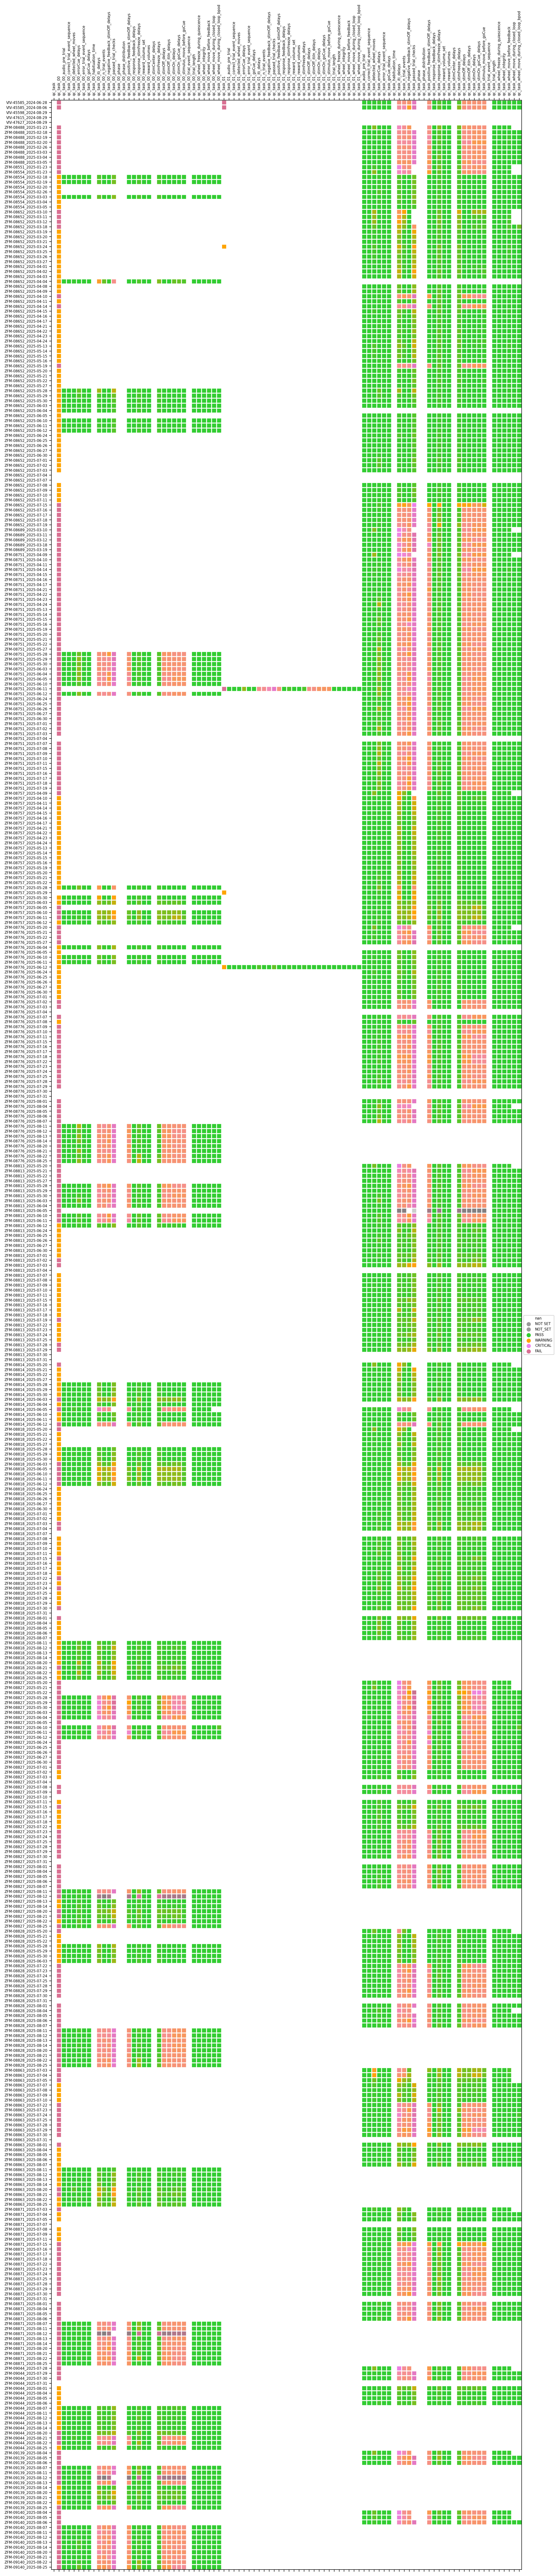

In [126]:
%matplotlib inline

# Select qc columns
qc_category = 'task'
qc_columns = [col for col in df_qc.columns if col.startswith(f'qc_{qc_category}')]

# Plot qc outcomes
fig, ax = plt.subplots(figsize=(0.15 * len(qc_columns), 0.15 * len(df_qc)))
ax = vis.qc_grid(df_qc, qc_columns, yticklabels=['subject', 'date'], ax=ax)

## Leftovers

In [50]:
import re

def violates_naming_convention(task_name: str) -> bool:
    """Returns True if the task name violates the standard IBL naming convention."""
    pattern = r'^_iblrig_tasks_(training|habituation|trainingPhase|passive|ephys|biased|advanced|neuromodulator)ChoiceWorld[\d\.\+\-\w]*$'
    return not re.match(pattern, task_name)
    
def follows_choiceworld_version_convention(task_name: str) -> bool:
    """Returns True if the task name ends with ChoiceWorldxx.yy.zz pattern."""
    pattern = r'ChoiceWorld\d+\.\d+\.\d+$'
    return not bool(re.search(pattern, task_name))

df_sessions['deviant_task_protocol'] = df_sessions['task_protocol'].apply(follows_choiceworld_version_convention)

In [ ]:
# Fill in missing targets using other sessions from the same subject
df_sessions = util.fill_empty_lists_from_group(df_sessions, 'target', 'subject')

# Guess missing NM values based on brain region targeted
df_sessions['NM'] = df_sessions.apply(
    lambda x: util.TARGET2NM[x['target'][0]] 
    if (x['NM'] == 'none') and x['target'] 
    else x['NM'], axis='columns'
)

In [ ]:
def _get_performance(series):
    try:
        df_trials = one.load_dataset(series['eid'], dataset='_ibl_trials.table.pqt')
        df_highcontrast = df_trials.query('(contrastRight == 1.) | (contrastLeft == 1.)')
        performance = df_highcontrast['feedbackType'].clip(0, 1).mean()
    except io.ALFObjectNotFound
        performance = np.nan
    return performance

df_recinfo.progress_apply(_get_performance, axis='columns')

  0%|          | 0/2446 [00:00<?, ?it/s]


(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-03-28/001/alf/task_00/_ibl_trials.table.fda945f7-1df1-45e6-abf1-2d7cc369c14b.pqt Bytes: 75169



  0%|                                    | 0/0.0716867446899414 [00:00<?, ?it/s]
100%|███████████| 0.0716867446899414/0.0716867446899414 [00:00<00:00,  5.63s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2024-01-24/001/alf/task_00/_ibl_trials.table.596361c9-a7f9-4619-8d2f-59037c99d44c.pqt Bytes: 38238



  0%|                                   | 0/0.03646659851074219 [00:00<?, ?it/s]
100%|█████████| 0.03646659851074219/0.03646659851074219 [00:00<00:00, 11.54s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2024-01-24/002/alf/task_00/_ibl_trials.table.539837b8-a9e6-42b3-8b67-2b4d696bb676.pqt Bytes: 29489



  0%|                                  | 0/0.028122901916503906 [00:00<?, ?it/s]
100%|███████| 0.028122901916503906/0.028122901916503906 [00:00<00:00,  5.73s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-01-19/001/alf/task_00/_ibl_trials.table.69934e89-de6d-4940-99f4-43ecc976f1ed.pqt Bytes: 89641



  0%|                                   | 0/0.08548831939697266 [00:00<?, ?it/s]
100%|█████████| 0.08548831939697266/0.08548831939697266 [00:00<00:00,  5.32s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2024-01-19/001/alf/task_00/_ibl_trials.table.b1c6fcc7-3e43-43a6-a30a-73e55b46836f.pqt Bytes: 28487



  0%|                                  | 0/0.027167320251464844 [00:00<?, ?it/s]
100%|███████| 0.027167320251464844/0.027167320251464844 [00:00<00:00,  5.54s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2024-01-19/001/alf/task_00/_ibl_trials.table.805ccf7c-e72a-4a34-852a-b9a20455fa68.pqt Bytes: 36460



  0%|                                  | 0/0.034770965576171875 [00:00<?, ?it/s]
100%|███████| 0.034770965576171875/0.034770965576171875 [00:00<00:00, 10.58s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2024-01-17/001/alf/task_00/_ibl_trials.table.7078b690-1960-44b4-bab8-11861dae2fc9.pqt Bytes: 56704



  0%|                                       | 0/0.0540771484375 [00:00<?, ?it/s]
100%|█████████████████| 0.0540771484375/0.0540771484375 [00:00<00:00,  6.04s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-01-17/001/alf/task_00/_ibl_trials.table.b37e001e-007b-4399-a472-40c997d4189d.pqt Bytes: 69310



  0%|                                   | 0/0.06609916687011719 [00:00<?, ?it/s]
100%|█████████| 0.06609916687011719/0.06609916687011719 [00:00<00:00,  6.06s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-01-16/001/alf/task_00/_ibl_trials.table.b819af36-d967-4ecf-b26c-b3cf11cd2eba.pqt Bytes: 63451



  0%|                                   | 0/0.06051158905029297 [00:00<?, ?it/s]
100%|█████████| 0.06051158905029297/0.06051158905029297 [00:00<00:00,  5.31s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2024-01-15/001/alf/task_00/_ibl_trials.table.d05e973a-659c-485d-a0b0-9107505d3e72.pqt Bytes: 29970



  0%|                                  | 0/0.028581619262695312 [00:00<?, ?it/s]
100%|███████| 0.028581619262695312/0.028581619262695312 [00:00<00:00,  7.07s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-01-12/001/alf/task_00/_ibl_trials.table.0d529933-3d17-4bdf-aa04-95f7d90585a3.pqt Bytes: 99961



  0%|                                   | 0/0.09533023834228516 [00:00<?, ?it/s]
100%|█████████| 0.09533023834228516/0.09533023834228516 [00:00<00:00,  4.75s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2024-01-12/001/alf/task_00/_ibl_trials.table.ad114058-f4f7-4295-9b4a-33305f5b8d92.pqt Bytes: 36877



  0%|                                   | 0/0.03516864776611328 [00:00<?, ?it/s]
100%|█████████| 0.03516864776611328/0.03516864776611328 [00:00<00:00, 11.45s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2024-01-10/001/alf/task_00/_ibl_trials.table.b22f4f7e-0398-4443-b831-cac9fc47c2a4.pqt Bytes: 68041



  0%|                                   | 0/0.06488895416259766 [00:00<?, ?it/s]
100%|█████████| 0.06488895416259766/0.06488895416259766 [00:00<00:00,  4.83s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2024-01-09/001/alf/task_00/_ibl_trials.table.a2d4b89d-ac03-4747-ba95-6f1d0bfa1d86.pqt Bytes: 56012



  0%|                                  | 0/0.053417205810546875 [00:00<?, ?it/s]
100%|███████| 0.053417205810546875/0.053417205810546875 [00:00<00:00,  7.39s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-12-28/001/alf/task_00/_ibl_trials.table.ae146c79-5387-4070-a3a2-1648e2e74b36.pqt Bytes: 32564



  0%|                                  | 0/0.031055450439453125 [00:00<?, ?it/s]
100%|███████| 0.031055450439453125/0.031055450439453125 [00:00<00:00,  4.90s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-12-27/001/alf/task_00/_ibl_trials.table.367daf9d-7617-4a7e-b0f9-c751d7313c6f.pqt Bytes: 17580



  0%|                                  | 0/0.016765594482421875 [00:00<?, ?it/s]
100%|███████| 0.016765594482421875/0.016765594482421875 [00:00<00:00, 11.95s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-12-27/001/alf/task_00/_ibl_trials.table.d84b812f-ba89-4509-91e0-5b5e6a9a1156.pqt Bytes: 51207



  0%|                                  | 0/0.048834800720214844 [00:00<?, ?it/s]
100%|███████| 0.048834800720214844/0.048834800720214844 [00:00<00:00,  9.89s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-12-22/001/alf/task_00/_ibl_trials.table.ed9b6484-f651-491a-b6cb-4940ced4d9f0.pqt Bytes: 32066



  0%|                                  | 0/0.030580520629882812 [00:00<?, ?it/s]
100%|███████| 0.030580520629882812/0.030580520629882812 [00:00<00:00,  6.93s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-12-22/001/alf/task_00/_ibl_trials.table.b8bf3133-9add-468a-a94e-1d1de8393a8e.pqt Bytes: 57199



  0%|                                  | 0/0.054549217224121094 [00:00<?, ?it/s]
100%|███████| 0.054549217224121094/0.054549217224121094 [00:00<00:00,  7.68s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-12-20/001/alf/task_00/_ibl_trials.table.dfb8c62a-88d1-4ac6-b3ae-65d69936de7c.pqt Bytes: 40226



  0%|                                   | 0/0.03836250305175781 [00:00<?, ?it/s]
100%|█████████| 0.03836250305175781/0.03836250305175781 [00:00<00:00, 12.30s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-12-06/001/alf/task_00/_ibl_trials.table.be90035d-d7e0-4573-a289-bece4c620d2d.pqt Bytes: 50091



  0%|                                   | 0/0.04777050018310547 [00:00<?, ?it/s]
100%|█████████| 0.04777050018310547/0.04777050018310547 [00:00<00:00,  6.82s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-12-06/001/alf/task_00/_ibl_trials.table.a5b9ca18-3ce4-4b8d-a1d3-e5ebfcda9868.pqt Bytes: 27810



  0%|                                  | 0/0.026521682739257812 [00:00<?, ?it/s]
100%|███████| 0.026521682739257812/0.026521682739257812 [00:00<00:00,  5.91s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-12-06/001/alf/task_00/_ibl_trials.table.af41fd08-3e14-4f2b-b523-5a4c4a5b3491.pqt Bytes: 45408



  0%|                                     | 0/0.043304443359375 [00:00<?, ?it/s]
100%|█████████████| 0.043304443359375/0.043304443359375 [00:00<00:00,  8.74s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-11-30/001/alf/task_00/_ibl_trials.table.35797f6f-e750-4c85-9505-795917131d2c.pqt Bytes: 39186



  0%|                                   | 0/0.03737068176269531 [00:00<?, ?it/s]
100%|█████████| 0.03737068176269531/0.03737068176269531 [00:00<00:00, 13.48s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-11-29/001/alf/task_00/_ibl_trials.table.bd655ef9-b480-4f5d-939c-467f9eb9eeed.pqt Bytes: 50506



  0%|                                   | 0/0.04816627502441406 [00:00<?, ?it/s]
100%|█████████| 0.04816627502441406/0.04816627502441406 [00:00<00:00,  7.46s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-11-28/001/alf/task_00/_ibl_trials.table.6bd05034-2e44-4de8-aa1e-3ce7ed89f5da.pqt Bytes: 22544



  0%|                                    | 0/0.0214996337890625 [00:00<?, ?it/s]
100%|███████████| 0.0214996337890625/0.0214996337890625 [00:00<00:00,  9.89s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-11-17/001/alf/task_00/_ibl_trials.table.aa3c0075-b522-47b8-8da3-b408cd4e3c26.pqt Bytes: 22012



  0%|                                  | 0/0.020992279052734375 [00:00<?, ?it/s]
100%|███████| 0.020992279052734375/0.020992279052734375 [00:00<00:00,  9.82s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-11-17/001/alf/task_00/_ibl_trials.table.85dc6221-db95-4d7d-aef5-3bce347f1fdd.pqt Bytes: 36259



  0%|                                   | 0/0.03457927703857422 [00:00<?, ?it/s]
100%|█████████| 0.03457927703857422/0.03457927703857422 [00:00<00:00, 11.68s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-11-16/001/alf/task_00/_ibl_trials.table.f70d4cfa-bc38-4c71-ad2d-066cfa869196.pqt Bytes: 48676



  0%|                                  | 0/0.046421051025390625 [00:00<?, ?it/s]
100%|███████| 0.046421051025390625/0.046421051025390625 [00:00<00:00,  8.81s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-11-15/001/alf/task_00/_ibl_trials.table.6405b31c-9e8b-4cb3-b068-2128cf844b17.pqt Bytes: 41389



  0%|                                   | 0/0.03947162628173828 [00:00<?, ?it/s]
100%|█████████| 0.03947162628173828/0.03947162628173828 [00:00<00:00, 10.18s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-11-15/001/alf/task_00/_ibl_trials.table.d16d9802-0597-432a-ba58-ba8efdc23987.pqt Bytes: 17811



  0%|                                   | 0/0.01698589324951172 [00:00<?, ?it/s]
100%|█████████| 0.01698589324951172/0.01698589324951172 [00:00<00:00, 11.88s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-11-14/001/alf/task_00/_ibl_trials.table.cc5d4390-ee81-433c-9ddc-ee9938fc883d.pqt Bytes: 40696



  0%|                                   | 0/0.03881072998046875 [00:00<?, ?it/s]
100%|█████████| 0.03881072998046875/0.03881072998046875 [00:00<00:00,  8.15s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-11-13/001/alf/task_00/_ibl_trials.table.f5c88fb9-d9d2-4bd7-948d-43e4154b7f04.pqt Bytes: 14758



  0%|                                  | 0/0.014074325561523438 [00:00<?, ?it/s]
100%|███████| 0.014074325561523438/0.014074325561523438 [00:00<00:00,  8.60s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2023-11-13/001/alf/task_00/_ibl_trials.table.89d29a87-a367-4b04-9740-0817dcb408f6.pqt Bytes: 27891



  0%|                                   | 0/0.02659893035888672 [00:00<?, ?it/s]
100%|█████████| 0.02659893035888672/0.02659893035888672 [00:00<00:00,  7.73s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-11-09/001/alf/task_00/_ibl_trials.table.6efc00bd-80fb-41e5-8823-4242caf426a9.pqt Bytes: 45226



  0%|                                   | 0/0.04313087463378906 [00:00<?, ?it/s]
100%|█████████| 0.04313087463378906/0.04313087463378906 [00:00<00:00,  7.52s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-11-03/001/alf/task_00/_ibl_trials.table.5fc08d06-1d96-457f-930f-9197dd45022d.pqt Bytes: 45735



  0%|                                  | 0/0.043616294860839844 [00:00<?, ?it/s]
100%|███████| 0.043616294860839844/0.043616294860839844 [00:00<00:00,  7.59s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-11-02/001/alf/task_00/_ibl_trials.table.f5d43751-c434-40fc-b495-5681b3b01318.pqt Bytes: 33098



  0%|                                   | 0/0.03156471252441406 [00:00<?, ?it/s]
100%|█████████| 0.03156471252441406/0.03156471252441406 [00:00<00:00,  5.20s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-11-02/001/alf/task_00/_ibl_trials.table.5e7f97c0-6ca9-42fb-8b15-23f68e56ffe8.pqt Bytes: 66277



  0%|                                   | 0/0.06320667266845703 [00:00<?, ?it/s]
100%|█████████| 0.06320667266845703/0.06320667266845703 [00:00<00:00,  6.52s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-10-26/001/alf/task_00/_ibl_trials.table.ae05f4ce-4c9e-4328-ba9b-c5d67c0c8e34.pqt Bytes: 66310



  0%|                                   | 0/0.06323814392089844 [00:00<?, ?it/s]
100%|█████████| 0.06323814392089844/0.06323814392089844 [00:00<00:00,  6.21s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-10-25/001/alf/task_00/_ibl_trials.table.6cdf2d11-8726-4e7c-be2e-9a71fb6c88fd.pqt Bytes: 83049



  0%|                                   | 0/0.07920169830322266 [00:00<?, ?it/s]
100%|█████████| 0.07920169830322266/0.07920169830322266 [00:00<00:00,  6.67s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-10-24/002/alf/task_00/_ibl_trials.table.d8389af8-1cb8-4943-a26b-48db784a35ad.pqt Bytes: 52881



  0%|                                  | 0/0.050431251525878906 [00:00<?, ?it/s]
100%|███████| 0.050431251525878906/0.050431251525878906 [00:00<00:00,  6.41s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-10-24/001/alf/task_00/_ibl_trials.table.49b1e384-5952-4687-8d29-dcacb8a0203f.pqt Bytes: 49303



  0%|                                  | 0/0.047019004821777344 [00:00<?, ?it/s]
100%|███████| 0.047019004821777344/0.047019004821777344 [00:00<00:00,  8.83s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-23/001/alf/task_00/_ibl_trials.table.5fbffb66-df31-418b-b722-d1ef6d4895d3.pqt Bytes: 34426



  0%|                                   | 0/0.03283119201660156 [00:00<?, ?it/s]
100%|█████████| 0.03283119201660156/0.03283119201660156 [00:00<00:00,  6.32s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-10-23/001/alf/task_00/_ibl_trials.table.ceb42e96-8ef9-4d83-b46e-64998be4e5fa.pqt Bytes: 43091



  0%|                                   | 0/0.04109477996826172 [00:00<?, ?it/s]
100%|█████████| 0.04109477996826172/0.04109477996826172 [00:00<00:00,  8.67s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-19/001/alf/task_00/_ibl_trials.table.0dc4acab-3c6f-467c-817f-600ce8c88c58.pqt Bytes: 33049



  0%|                                  | 0/0.031517982482910156 [00:00<?, ?it/s]
100%|███████| 0.031517982482910156/0.031517982482910156 [00:00<00:00,  6.22s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-10-19/001/alf/task_00/_ibl_trials.table.64f453b2-d065-4ccc-b95d-2d26b31ed08d.pqt Bytes: 59283



  0%|                                   | 0/0.05653667449951172 [00:00<?, ?it/s]
100%|█████████| 0.05653667449951172/0.05653667449951172 [00:00<00:00,  6.11s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-10-18/001/alf/task_00/_ibl_trials.table.80b26c67-49e0-4ed7-9e28-a21d6a2c52f4.pqt Bytes: 72679



  0%|                                   | 0/0.06931209564208984 [00:00<?, ?it/s]
100%|█████████| 0.06931209564208984/0.06931209564208984 [00:00<00:00,  4.55s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-18/001/alf/task_00/_ibl_trials.table.fd3e670b-492e-4a70-a1bc-6b081b8bad0c.pqt Bytes: 31143



  0%|                                  | 0/0.029700279235839844 [00:00<?, ?it/s]
100%|███████| 0.029700279235839844/0.029700279235839844 [00:00<00:00,  6.92s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-10/001/alf/task_00/_ibl_trials.table.ae3d4df8-47dc-4136-9d1f-13b0a33c7d3e.pqt Bytes: 15144



  0%|                                   | 0/0.01444244384765625 [00:00<?, ?it/s]
100%|█████████| 0.01444244384765625/0.01444244384765625 [00:00<00:00, 11.65s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-10-09/001/alf/task_00/_ibl_trials.table.9db1b224-89e0-45d0-bf03-0841a5494302.pqt Bytes: 14110



  0%|                                  | 0/0.013456344604492188 [00:00<?, ?it/s]
100%|███████| 0.013456344604492188/0.013456344604492188 [00:00<00:00, 11.55s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-10-06/001/alf/task_00/_ibl_trials.table.08862ca9-5897-418c-b4e1-7b3e5f3e7815.pqt Bytes: 28071



  0%|                                  | 0/0.026770591735839844 [00:00<?, ?it/s]
100%|███████| 0.026770591735839844/0.026770591735839844 [00:00<00:00,  7.47s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-06/001/alf/task_00/_ibl_trials.table.53a6a144-5baf-44cc-a19b-d159a709362e.pqt Bytes: 43240



  0%|                                   | 0/0.04123687744140625 [00:00<?, ?it/s]
100%|█████████| 0.04123687744140625/0.04123687744140625 [00:00<00:00,  7.64s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-10-05/001/alf/task_00/_ibl_trials.table.a8f38c87-ec52-47fa-b4dc-12cf8aa41515.pqt Bytes: 45062



  0%|                                   | 0/0.04297447204589844 [00:00<?, ?it/s]
100%|█████████| 0.04297447204589844/0.04297447204589844 [00:00<00:00,  9.33s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-10-05/001/alf/task_00/_ibl_trials.table.e6f7f48d-96f9-4d3d-87c9-611f91e2fda2.pqt Bytes: 54331



  0%|                                   | 0/0.05181407928466797 [00:00<?, ?it/s]
100%|█████████| 0.05181407928466797/0.05181407928466797 [00:00<00:00,  6.12s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-10-04/001/alf/task_00/_ibl_trials.table.2ea52a03-eb5e-4e14-afdd-0d4c6fe71e96.pqt Bytes: 45249



  0%|                                  | 0/0.043152809143066406 [00:00<?, ?it/s]
100%|███████| 0.043152809143066406/0.043152809143066406 [00:00<00:00,  9.47s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-10-03/001/alf/task_00/_ibl_trials.table.99d8e0a4-3ce6-4182-ade7-5c117754dca8.pqt Bytes: 22233



  0%|                                  | 0/0.021203041076660156 [00:00<?, ?it/s]
100%|███████| 0.021203041076660156/0.021203041076660156 [00:00<00:00,  7.19s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-10-03/001/alf/task_00/_ibl_trials.table.30e6aca0-5724-4209-b0fc-c0c9184cb733.pqt Bytes: 63199



  0%|                                  | 0/0.060271263122558594 [00:00<?, ?it/s]
100%|███████| 0.060271263122558594/0.060271263122558594 [00:00<00:00,  6.82s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-10-02/001/alf/task_00/_ibl_trials.table.4fc0abce-8952-4f40-ab25-ed1d4d756e67.pqt Bytes: 86177



  0%|                                    | 0/0.0821847915649414 [00:00<?, ?it/s]
100%|███████████| 0.0821847915649414/0.0821847915649414 [00:00<00:00,  7.45s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-10-02/001/alf/task_00/_ibl_trials.table.b8f5629f-77ad-4af7-a304-6b052a112e4c.pqt Bytes: 36443



  0%|                                   | 0/0.03475475311279297 [00:00<?, ?it/s]
100%|█████████| 0.03475475311279297/0.03475475311279297 [00:00<00:00, 11.65s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-09-28/001/alf/task_00/_ibl_trials.table.5ee9513e-9a1d-410e-ba3e-fa90cd7c2692.pqt Bytes: 13339



  0%|                                  | 0/0.012721061706542969 [00:00<?, ?it/s]
100%|███████| 0.012721061706542969/0.012721061706542969 [00:00<00:00, 15.81s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-09-18/001/alf/task_00/_ibl_trials.table.fe6f7318-ebbe-4975-a8cd-90f5fa73eacf.pqt Bytes: 25906



  0%|                                  | 0/0.024705886840820312 [00:00<?, ?it/s]
100%|███████| 0.024705886840820312/0.024705886840820312 [00:00<00:00,  6.06s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-09-15/001/alf/task_00/_ibl_trials.table.d066d39b-00de-4a4f-a831-0f4afa692180.pqt Bytes: 20550



  0%|                                  | 0/0.019598007202148438 [00:00<?, ?it/s]
100%|███████| 0.019598007202148438/0.019598007202148438 [00:00<00:00, 10.27s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-09-15/001/alf/task_00/_ibl_trials.table.d83b77c3-6958-4c76-b701-1487acd58acd.pqt Bytes: 35913



  0%|                                  | 0/0.034249305725097656 [00:00<?, ?it/s]
100%|███████| 0.034249305725097656/0.034249305725097656 [00:00<00:00,  9.12s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-09-14/001/alf/task_00/_ibl_trials.table.f64a633e-7a23-4899-adcf-67af18cbac77.pqt Bytes: 21973



  0%|                                   | 0/0.02095508575439453 [00:00<?, ?it/s]
100%|█████████| 0.02095508575439453/0.02095508575439453 [00:00<00:00,  7.71s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-09-07/001/alf/task_00/_ibl_trials.table.b96faa36-2f41-4afb-9a9e-39332d0535b4.pqt Bytes: 30077



  0%|                                   | 0/0.02868366241455078 [00:00<?, ?it/s]
100%|█████████| 0.02868366241455078/0.02868366241455078 [00:00<00:00,  5.63s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-09-05/001/alf/task_00/_ibl_trials.table.5fc638cf-878e-41a1-a16d-38c526eb1fc2.pqt Bytes: 20615



  0%|                                  | 0/0.019659996032714844 [00:00<?, ?it/s]
100%|███████| 0.019659996032714844/0.019659996032714844 [00:00<00:00,  8.20s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-09-05/001/alf/task_00/_ibl_trials.table.7a63eb3a-88d3-462e-ac3e-29f88e1ef460.pqt Bytes: 28275



  0%|                                   | 0/0.02696514129638672 [00:00<?, ?it/s]
100%|█████████| 0.02696514129638672/0.02696514129638672 [00:00<00:00,  7.51s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-08-31/001/alf/task_00/_ibl_trials.table.c472b87a-3e9c-475c-9f62-daac149ab7da.pqt Bytes: 25359



  0%|                                  | 0/0.024184226989746094 [00:00<?, ?it/s]
100%|███████| 0.024184226989746094/0.024184226989746094 [00:00<00:00,  8.98s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-08-31/001/alf/_ibl_trials.table.fcb55d68-438d-4f84-bc49-52c1e48e6cad.pqt Bytes: 50552



  0%|                                   | 0/0.04821014404296875 [00:00<?, ?it/s]
100%|█████████| 0.04821014404296875/0.04821014404296875 [00:00<00:00,  8.64s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-08-29/002/alf/_ibl_trials.table.507498b1-898a-4949-be44-e93c7a686b83.pqt Bytes: 41410



  0%|                                   | 0/0.03949165344238281 [00:00<?, ?it/s]
100%|█████████| 0.03949165344238281/0.03949165344238281 [00:00<00:00, 10.33s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-08-28/001/alf/task_00/_ibl_trials.table.630a2db0-70c4-4a74-8c61-95382d8bbcb9.pqt Bytes: 25667



  0%|                                   | 0/0.02447795867919922 [00:00<?, ?it/s]
100%|█████████| 0.02447795867919922/0.02447795867919922 [00:00<00:00,  6.52s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-08-23/001/alf/_ibl_trials.table.fba2ec95-a1ef-466c-865b-f0c3f48afa0e.pqt Bytes: 41547



  0%|                                   | 0/0.03962230682373047 [00:00<?, ?it/s]
100%|█████████| 0.03962230682373047/0.03962230682373047 [00:00<00:00,  8.91s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-08-22/001/alf/_ibl_trials.table.03f06632-826c-4376-b785-8abfdb19ef74.pqt Bytes: 54498



  0%|                                   | 0/0.05197334289550781 [00:00<?, ?it/s]
100%|█████████| 0.05197334289550781/0.05197334289550781 [00:00<00:00,  8.00s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-08-22/001/alf/_ibl_trials.table.06936d98-17d5-4049-ae64-91e486d0a0a9.pqt Bytes: 44172



  0%|                                  | 0/0.042125701904296875 [00:00<?, ?it/s]
100%|███████| 0.042125701904296875/0.042125701904296875 [00:00<00:00,  9.45s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-08-22/001/alf/_ibl_trials.table.4ce9b0fd-5bd5-47b2-8598-2e929ae4b79e.pqt Bytes: 71430



  0%|                                   | 0/0.06812095642089844 [00:00<?, ?it/s]
100%|█████████| 0.06812095642089844/0.06812095642089844 [00:00<00:00,  4.72s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-08-18/001/alf/_ibl_trials.table.24b51c48-09e1-47ee-93e3-8df44432f392.pqt Bytes: 22518



  0%|                                  | 0/0.021474838256835938 [00:00<?, ?it/s]
100%|███████| 0.021474838256835938/0.021474838256835938 [00:00<00:00,  8.68s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-08-18/001/alf/_ibl_trials.table.76dddbdb-8de7-4765-9ecd-7ea745dcf755.pqt Bytes: 53822



  0%|                                   | 0/0.05132865905761719 [00:00<?, ?it/s]
100%|█████████| 0.05132865905761719/0.05132865905761719 [00:00<00:00,  6.35s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-08-17/001/alf/task_00/_ibl_trials.table.1ba3539e-2243-41e3-91b5-79b190cc44cb.pqt Bytes: 16480



  0%|                                     | 0/0.015716552734375 [00:00<?, ?it/s]
100%|█████████████| 0.015716552734375/0.015716552734375 [00:00<00:00, 10.50s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-08-17/001/alf/_ibl_trials.table.e31d90a0-72c3-4d15-bac5-9b9009ca3aba.pqt Bytes: 36008



  0%|                                   | 0/0.03433990478515625 [00:00<?, ?it/s]
100%|█████████| 0.03433990478515625/0.03433990478515625 [00:00<00:00, 10.45s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-08-17/002/alf/_ibl_trials.table.6cd444a5-281c-4ee1-86e6-90ae7e25feb7.pqt Bytes: 61055



  0%|                                  | 0/0.058226585388183594 [00:00<?, ?it/s]
100%|███████| 0.058226585388183594/0.058226585388183594 [00:00<00:00,  6.98s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-08-16/001/alf/_ibl_trials.table.0459e8b7-5a1b-408c-81e7-758d1bfef9ae.pqt Bytes: 34661



  0%|                                   | 0/0.03305530548095703 [00:00<?, ?it/s]
100%|█████████| 0.03305530548095703/0.03305530548095703 [00:00<00:00,  6.14s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-08-15/001/alf/task_00/_ibl_trials.table.44459c4c-6fb9-4b87-8d69-7dbd47b28727.pqt Bytes: 29617



  0%|                                  | 0/0.028244972229003906 [00:00<?, ?it/s]
100%|███████| 0.028244972229003906/0.028244972229003906 [00:00<00:00,  5.60s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-07-25/002/alf/task_00/_ibl_trials.table.026bbae1-a3d3-4fc4-9698-6502188c029e.pqt Bytes: 28922



  0%|                                  | 0/0.027582168579101562 [00:00<?, ?it/s]
100%|███████| 0.027582168579101562/0.027582168579101562 [00:00<00:00,  7.42s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-25/001/alf/_ibl_trials.table.05bae42a-3971-42a9-a322-fec9db911a4b.pqt Bytes: 22225



  0%|                                  | 0/0.021195411682128906 [00:00<?, ?it/s]
100%|███████| 0.021195411682128906/0.021195411682128906 [00:00<00:00,  7.22s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-07-24/001/alf/_ibl_trials.table.772e734f-232a-469a-ae28-1be9b7ef5d07.pqt Bytes: 49202



  0%|                                   | 0/0.04692268371582031 [00:00<?, ?it/s]
100%|█████████| 0.04692268371582031/0.04692268371582031 [00:00<00:00,  8.47s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-07-21/001/alf/_ibl_trials.table.c7ca54ae-70ce-406f-859e-ab565a9ea918.pqt Bytes: 63273



  0%|                                  | 0/0.060341835021972656 [00:00<?, ?it/s]
100%|███████| 0.060341835021972656/0.060341835021972656 [00:00<00:00,  7.77s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-18/001/alf/task_00/_ibl_trials.table.e13ef817-2475-42c7-8a65-db919a1d6022.pqt Bytes: 23542



  0%|                                  | 0/0.022451400756835938 [00:00<?, ?it/s]
100%|███████| 0.022451400756835938/0.022451400756835938 [00:00<00:00,  9.02s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-07-18/002/alf/task_00/_ibl_trials.table.7a73a72e-da28-4a43-8733-9092b37069d8.pqt Bytes: 19212



  0%|                                  | 0/0.018321990966796875 [00:00<?, ?it/s]
100%|███████| 0.018321990966796875/0.018321990966796875 [00:00<00:00,  9.63s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-18/001/alf/_ibl_trials.table.fa0eab08-fd97-4c4b-bff8-5035cdd896ac.pqt Bytes: 38730



  0%|                                   | 0/0.03693580627441406 [00:00<?, ?it/s]
100%|█████████| 0.03693580627441406/0.03693580627441406 [00:00<00:00, 11.92s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-17/001/alf/_ibl_trials.table.a1f0c3df-5d5a-43d6-b4f2-aad563ad9b64.pqt Bytes: 21317



  0%|                                   | 0/0.02032947540283203 [00:00<?, ?it/s]
100%|█████████| 0.02032947540283203/0.02032947540283203 [00:00<00:00,  7.80s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-07-14/001/alf/_ibl_trials.table.7fbe147d-f94d-4350-bb48-01cb43c55e8e.pqt Bytes: 80249



  0%|                                   | 0/0.07653141021728516 [00:00<?, ?it/s]
100%|█████████| 0.07653141021728516/0.07653141021728516 [00:00<00:00,  5.06s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-14/001/alf/_ibl_trials.table.d42189f2-aaaa-425f-b67c-763cfe5a43fa.pqt Bytes: 90705



  0%|                                    | 0/0.0865030288696289 [00:00<?, ?it/s]
100%|███████████| 0.0865030288696289/0.0865030288696289 [00:00<00:00, 11.16s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-07-14/001/alf/task_00/_ibl_trials.table.7b985802-89dc-4ad4-97bc-a871ee28254a.pqt Bytes: 19756



  0%|                                  | 0/0.018840789794921875 [00:00<?, ?it/s]
100%|███████| 0.018840789794921875/0.018840789794921875 [00:00<00:00,  9.12s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-12/008/alf/_ibl_trials.table.be2adb3f-fbc3-45e1-90dd-713186d45ddd.pqt Bytes: 86107



  0%|                                   | 0/0.08211803436279297 [00:00<?, ?it/s]
100%|█████████| 0.08211803436279297/0.08211803436279297 [00:00<00:00,  6.15s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-07-12/001/alf/_ibl_trials.table.dc4e4c32-06d2-4e92-8f1a-e5dac748b2f1.pqt Bytes: 21239



  0%|                                  | 0/0.020255088806152344 [00:00<?, ?it/s]
100%|███████| 0.020255088806152344/0.020255088806152344 [00:00<00:00,  8.79s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-11/001/alf/_ibl_trials.table.2dca0988-44ab-4925-b77c-1cb2cd52aad2.pqt Bytes: 28933



  0%|                                   | 0/0.02759265899658203 [00:00<?, ?it/s]
100%|█████████| 0.02759265899658203/0.02759265899658203 [00:00<00:00,  5.78s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-11/001/alf/_ibl_trials.table.f39e5cd2-6010-41c2-8cb8-f1017612deab.pqt Bytes: 82584



  0%|                                   | 0/0.07875823974609375 [00:00<?, ?it/s]
100%|█████████| 0.07875823974609375/0.07875823974609375 [00:00<00:00,  7.23s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-07-11/001/alf/_ibl_trials.table.941242cd-c278-495f-bcf7-cd71b232d7f5.pqt Bytes: 23506



  0%|                                  | 0/0.022417068481445312 [00:00<?, ?it/s]
100%|███████| 0.022417068481445312/0.022417068481445312 [00:00<00:00,  6.71s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-10/001/alf/_ibl_trials.table.d841f267-36a7-4872-b048-3500625ffac0.pqt Bytes: 20768



  0%|                                     | 0/0.019805908203125 [00:00<?, ?it/s]
100%|█████████████| 0.019805908203125/0.019805908203125 [00:00<00:00,  8.54s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-10/001/alf/_ibl_trials.table.0802d7d8-9137-4589-a9b3-2548a9784710.pqt Bytes: 35388



  0%|                                  | 0/0.033748626708984375 [00:00<?, ?it/s]
100%|███████| 0.033748626708984375/0.033748626708984375 [00:00<00:00, 11.35s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-07-10/002/alf/_ibl_trials.table.e565f2c0-5be7-4440-a173-045ffcc2a40b.pqt Bytes: 14556



  0%|                                  | 0/0.013881683349609375 [00:00<?, ?it/s]
100%|███████| 0.013881683349609375/0.013881683349609375 [00:00<00:00, 14.64s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-07-07/001/alf/task_00/_ibl_trials.table.7f338481-0c55-4adb-862d-456305795a7a.pqt Bytes: 57461



  0%|                                   | 0/0.05479907989501953 [00:00<?, ?it/s]
100%|█████████| 0.05479907989501953/0.05479907989501953 [00:00<00:00,  7.62s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-05/001/alf/_ibl_trials.table.4183e9ad-81e1-4ab6-baa7-d8e6491ff769.pqt Bytes: 52719



  0%|                                  | 0/0.050276756286621094 [00:00<?, ?it/s]
100%|███████| 0.050276756286621094/0.050276756286621094 [00:00<00:00,  6.99s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-04/001/alf/_ibl_trials.table.6ce57077-3345-4716-8798-73fc6c72f048.pqt Bytes: 46105



  0%|                                  | 0/0.043969154357910156 [00:00<?, ?it/s]
100%|███████| 0.043969154357910156/0.043969154357910156 [00:00<00:00, 17.57s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2023-07-03/001/alf/_ibl_trials.table.1cdecfc9-f88c-4dca-84b2-99134e2309e3.pqt Bytes: 22180



  0%|                                  | 0/0.021152496337890625 [00:00<?, ?it/s]
100%|███████| 0.021152496337890625/0.021152496337890625 [00:00<00:00, 10.09s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-03/001/alf/_ibl_trials.table.ef97048c-15c8-49f8-af08-b93c260c3979.pqt Bytes: 30061



  0%|                                   | 0/0.02866840362548828 [00:00<?, ?it/s]
100%|█████████| 0.02866840362548828/0.02866840362548828 [00:00<00:00,  7.33s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05236/2023-06-27/001/alf/_ibl_trials.table.3101b537-4c74-4159-abab-38faeac0df71.pqt Bytes: 52299



  0%|                                   | 0/0.04987621307373047 [00:00<?, ?it/s]
100%|█████████| 0.04987621307373047/0.04987621307373047 [00:00<00:00,  6.43s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-06-27/001/alf/_ibl_trials.table.46b2c9b7-94e1-4730-acb4-27ae9d90834b.pqt Bytes: 81026



  0%|                                   | 0/0.07727241516113281 [00:00<?, ?it/s]
100%|█████████| 0.07727241516113281/0.07727241516113281 [00:00<00:00,  4.43s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-06-27/001/alf/_ibl_trials.table.b4f4ecf1-8bba-443f-87d0-0322288e0c0c.pqt Bytes: 52089



  0%|                                  | 0/0.049675941467285156 [00:00<?, ?it/s]
100%|███████| 0.049675941467285156/0.049675941467285156 [00:00<00:00,  7.39s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-06-22/001/alf/_ibl_trials.table.da794512-335e-4377-8a1a-7232ac2950d9.pqt Bytes: 65316



  0%|                                  | 0/0.062290191650390625 [00:00<?, ?it/s]
100%|███████| 0.062290191650390625/0.062290191650390625 [00:00<00:00, 12.89s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-06-21/001/alf/_ibl_trials.table.dfd5fa58-b901-425c-91d7-fb1a8fee2101.pqt Bytes: 49305



  0%|                                  | 0/0.047020912170410156 [00:00<?, ?it/s]
100%|███████| 0.047020912170410156/0.047020912170410156 [00:00<00:00,  7.80s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-06-20/001/alf/_ibl_trials.table.0ddfff41-4b0f-47ff-ae3b-72cc1d7a6ec8.pqt Bytes: 17571



  0%|                                   | 0/0.01675701141357422 [00:00<?, ?it/s]
100%|█████████| 0.01675701141357422/0.01675701141357422 [00:00<00:00, 13.30s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-06-20/002/alf/_ibl_trials.table.531a1457-eb83-4154-8fae-e3a10b74e777.pqt Bytes: 49205



  0%|                                   | 0/0.04692554473876953 [00:00<?, ?it/s]
100%|█████████| 0.04692554473876953/0.04692554473876953 [00:00<00:00,  6.86s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-06-15/002/alf/_ibl_trials.table.79027d8a-aa04-4e53-8d7b-d8b3dd3d46bb.pqt Bytes: 55067



  0%|                                   | 0/0.05251598358154297 [00:00<?, ?it/s]
100%|█████████| 0.05251598358154297/0.05251598358154297 [00:00<00:00,  6.10s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/s

In [95]:
from one.alf import spec

for qc in spec.QC:
    qc = str(qc).split('.')[1]
    eids_qc = one.search(projects='ibl_fibrephotometry', qc=qc)
    print(qc, len(eids_qc))
    # df_recinfo[qc] = df_recinfo.apply(lambda x: x['eid'] in list(eids_qc), axis='columns')

CRITICAL 0
FAIL 2309
WARNING 27
NOT_SET 110
PASS 0


In [8]:
cache_dir = '/home/crombie/mnt/ccu-iblserver/kb/data/one'
one = ONE(cache_dir=cache_dir)

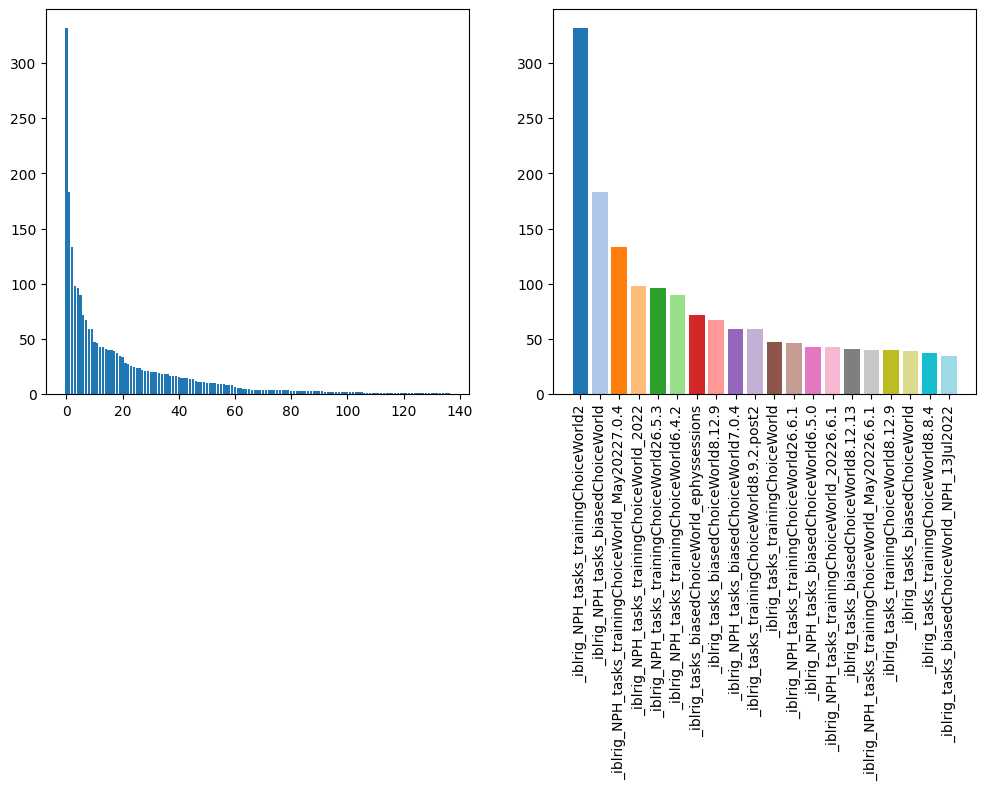

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
df_protocols = df_recinfo['task_protocol'].value_counts()
axs[0].bar(np.arange(len(df_protocols)), df_protocols.values)
axs[1].bar(np.arange(20), df_protocols.head(20).values, color=plt.cm.tab20(np.arange(20)))
axs[1].set_xticks(np.arange(20))
axs[1].set_xticklabels(df_protocols.head(20).index)
axs[1].tick_params(axis='x', labelrotation=90)

In [2]:
df_sessions = pd.read_parquet(config.SESSIONS_FPATH)

In [26]:
df_sessions.value_counts()

_ibl_wheel.position.npy
True     2992
False     382
Name: count, dtype: int64

In [20]:
df_sessions['session_type'] = df_sessions['task_protocol'].apply(util.protocol2type)

In [23]:
df_sessions.query('session_type == "misc"')['task_protocol'].value_counts()

task_protocol
_iblrig_tasks_biasedChoiceWorld_RPE6.5.3                 8
_iblrig_tasks_habituationChoiceWorld_3delays             5
_iblrig_tasks_habituationChoiceWorld_fixed_delay         4
_iblrig_tasks_biasedChoiceWorld_FEEDBACK_DELAY           4
_iblrig_tasks_trainingPhaseChoiceWorld8.29.0             3
_iblrig_tasks_habituationChoiceWorld_3delays7.0.4        3
_iblrig_tasks_habituationChoiceWorld_fixed_delay7.0.4    3
_iblrig_tasks_trainingPhaseChoiceWorld8.8.4              1
_iblrig_tasks_passiveMockChoiceWorld7.2.0                1
Name: count, dtype: int64